# Proyecto Final - Kickstarter
## ITESM Campus Guadalajara
### Escuela de Ingeniería y Ciencias
### Maestría en Ciencias de la Computación
### Dr. Luis Eduardo Falcón Morales
### Elisa Fernandez Castillo A01221781
### Gabriel Briones Sayeg A01222517

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# Modelo lineal
from sklearn.linear_model import LogisticRegression

# MLP
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import accuracy_score, r2_score, classification_report, confusion_matrix

# Arboles
from sklearn.tree import DecisionTreeClassifier

# SVM
from sklearn.svm import SVC

encoder = preprocessing.LabelEncoder()

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/TecnicasAprendizajeAutomatico/ProyectoFinal')
# os.chdir(r'Documents/Personal/MCC/ks-projects-201801.csv/')
# print(os.getcwd())
# print(os.listdir())

Mounted at /content/drive


In [ ]:
data = pd.read_csv('ks-projects-201801.csv')

In [ ]:
print(data.columns)
print(data.shape)

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')
(378661, 15)


In [ ]:
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


**La solución debe tener las siguientes características:**

---

**a. Incluir una introducción que explique las características de la problemática y el objetivo del problema (clasificación o regresión) a resolver.**

Kickstarter es una plataforma de financiamiento para proyectos creativos de todo tipo. Kickstarter facilita la captación de recursos monetarios del público en en general. Los dueños del proyecto eligen una fecha límite y un mínimo objetivo de fondos a recaudar. El dinero prometido por los donantes se recopila mediante Amazon Payments. Si el objetivo elegido no es recolectado en el plazo, no se perciben fondos (esto se conoce como provision point mechanism). Kickstarter toma un 5% de los fondos recaudados y Amazon cobra un 3-5% adicional

**b. Indicar claramente cuáles son las variables de entrada (factores características o variables independientes), así como la variable de salida (dependiente). Indicar el tipo de variables: numéricas, categóricas, binarias, etc.**

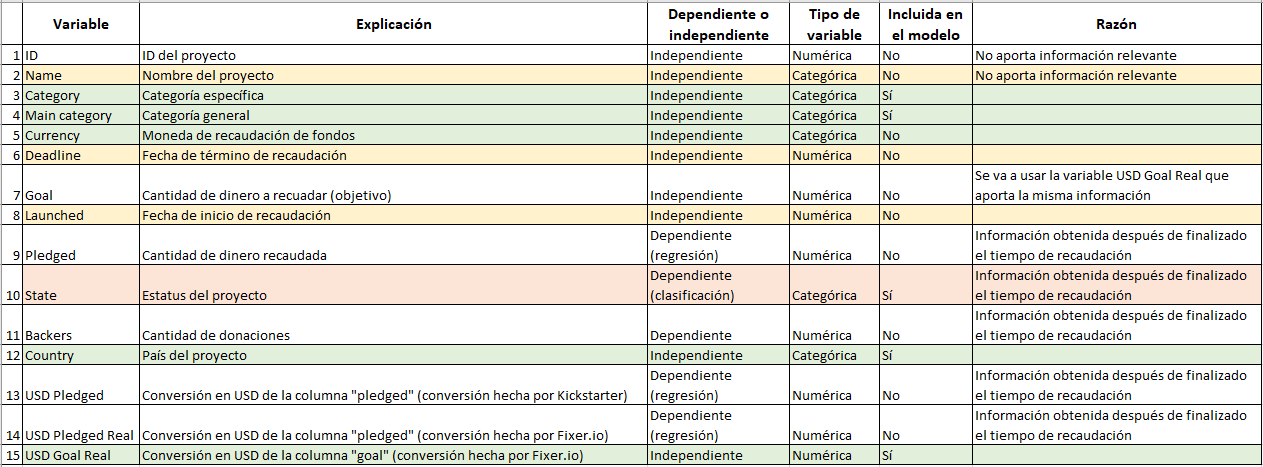

Las variables mostradas en verde se usarán como variables independientes en nuestro modelo mientras que la variable mostrada en rojo será la variable dependeinte. Las variables amarillas serán rediseñadas para obtener más datos en el modelo y las variables en blanco serán descartadas por las razones que de indican en las columnas. El problema será de clasificación.

In [ ]:
for col in data:
  column = data[col]
  if column.dtype.name == 'object'and col not in ['deadline','launched']:
    categories = column.unique()
    num_cat = len(categories)
    
    if num_cat < 100:
     print(col,": ", num_cat)
     print(" \tCategories: ",categories)
    else:
     print(col,": ",  num_cat)
    print()

name :  375765

category :  159

main_category :  15
 	Categories:  ['Publishing' 'Film & Video' 'Music' 'Food' 'Design' 'Crafts' 'Games'
 'Comics' 'Fashion' 'Theater' 'Art' 'Photography' 'Technology' 'Dance'
 'Journalism']

currency :  14
 	Categories:  ['GBP' 'USD' 'CAD' 'AUD' 'NOK' 'EUR' 'MXN' 'SEK' 'NZD' 'CHF' 'DKK' 'HKD'
 'SGD' 'JPY']

state :  6
 	Categories:  ['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']

country :  23
 	Categories:  ['GB' 'US' 'CA' 'AU' 'NO' 'IT' 'DE' 'IE' 'MX' 'ES' 'N,0"' 'SE' 'FR' 'NL'
 'NZ' 'CH' 'AT' 'DK' 'BE' 'HK' 'LU' 'SG' 'JP']



## **Preprocesamiento de datos**

### Generación de nuevas variables
De los datos con los que contamos podemos generar nuevas variables que pueden dar más información sobre los proyectos que pueden ayudar a las predicciones. Entre las variables nuevas que se pueden generar se encuentran:


*   Duración de la recaudación (campaign_length) en días
*   Longitud del nombre del proyecto (name_length)
*   Mes en el que la recaudación comenzó (start_month)
*   Mes en el que la recaudación terminó (end_month)
*   Día de la semana en el que rempezó la recaudación (start_day) The day of the week with Monday=0, Sunday=6.
*   Día de la semana en el que terminó la recaudación (end_day)




In [ ]:
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [ ]:
data['deadline'] = pd.to_datetime(data['deadline'])
data['launched'] = pd.to_datetime(data['launched'])
data['start_day'] = data['launched'].dt.dayofweek
data['end_day'] = data['deadline'].dt.dayofweek
data['start_month'] = data['launched'].dt.month
data['end_month'] = data['deadline'].dt.month
data['year'] = data['launched'].dt.year
data['name_length'] = data['name'].str.len()
data['campaign_length'] = (data['deadline'] - data['launched']) /np.timedelta64(1,'D')

In [ ]:
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,start_day,end_day,start_month,end_month,year,name_length,campaign_length
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,1,4,8,10,2015,31.0,58.491343
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,5,2,9,11,2017,45.0,59.802813
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,5,1,1,2,2013,14.0,44.985532
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,5,0,3,4,2012,49.0,29.858206
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,5,5,7,8,2015,58.0,55.642326


In [ ]:
data.shape

(378661, 22)

Ahora se eliminarán las variables que no nos sirven para el modelo (ver Tabla en la sección de arriba).

In [ ]:
# data_filtered = data_filtered.drop(['ID','name','goal','pledged','backers','usd pledged','state','deadline','launched'],axis=1)
# Sin remover state para que sea un problema de calsificación
data = data.drop(['ID','name','goal','pledged','backers','usd pledged','deadline','launched','usd_pledged_real'],axis=1)


In [ ]:
data.head()

,category,main_category,currency,state,country,usd_goal_real,start_day,end_day,start_month,end_month,year,name_length,campaign_length
0,Poetry,Publishing,GBP,failed,GB,1533.95,1,4,8,10,2015,31.0,58.491343
1,Narrative Film,Film & Video,USD,failed,US,30000.00,5,2,9,11,2017,45.0,59.802813
2,Narrative Film,Film & Video,USD,failed,US,45000.00,5,1,1,2,2013,14.0,44.985532
3,Music,Music,USD,failed,US,5000.00,5,0,3,4,2012,49.0,29.858206
4,Film & Video,Film & Video,USD,canceled,US,19500.00,5,5,7,8,2015,58.0,55.642326


### Gráficas exploratorias

*Estatus de los proyectos*

In [ ]:
success_projects = data[data['state'] == 'successful']['state'].count()
failed_projects = data[data['state'] == 'failed']['state'].count()
other_projects = (data[data['state'] == 'canceled']['state'].count() + data[data['state'] == 'live']['state'].count() + data[data['state'] == 'undefined']['state'].count()+ data[data['state'] == 'suspended']['state'].count())

Text(0.5, 1.0, 'Total Success Rate')

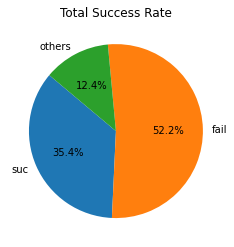

In [ ]:
total_state = success_projects + failed_projects + other_projects
suc = success_projects/total_state
fail = failed_projects/total_state
other = other_projects/total_state
sizes = [suc,fail,other]
labels='suc','fail','others'
plt.pie(sizes,labels=labels,autopct='%1.1f%%',startangle=140)
plt.title("Total Success Rate")

In [ ]:
success_percentage = (data['state'].value_counts())/len(data['state'])

In [ ]:
pd.DataFrame(success_percentage)*100

,state
failed,52.215306
successful,35.376234
canceled,10.241086
undefined,0.940683
live,0.739184
suspended,0.487507


*País de origen de los proyectos*

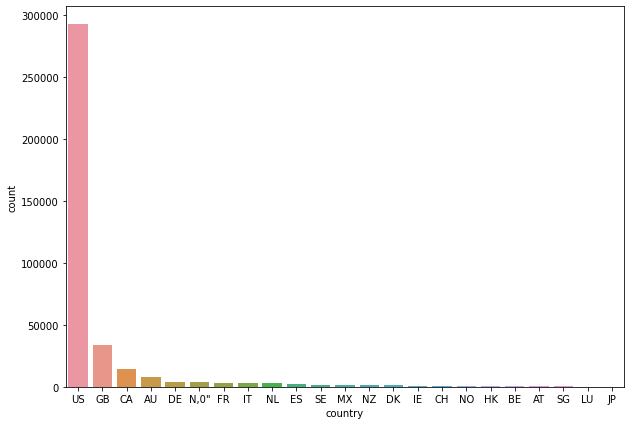

In [ ]:
country=data['country'].value_counts()
country_percentage =(country/len(data['country']))

# labels = np.array(data['country'].value_counts().index)
# plt.pie(x=country_percentage,labels=labels,autopct="%.1f%%",explode=[0.25]*len(labels),pctdistance=1)
plt.subplots(figsize=(10,7))
sns.countplot(x='country',data=data,order=data['country'].value_counts().index)

In [ ]:
pd.DataFrame(country_percentage *100)

,country
US,77.279414
GB,8.892387
CA,3.896889
AU,2.070189
DE,1.101513
"N,0""",1.002744
FR,0.776156
IT,0.760047
NL,0.757406
ES,0.601065


*Categoría principal de los proyectos*

In [ ]:
main_category = data['main_category'].value_counts()
main_category_percentage = main_category/len(data['main_category'])

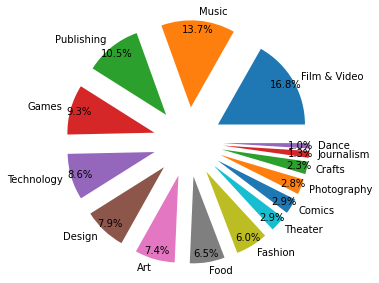

In [ ]:
plt.pie(main_category_percentage,labels=main_category_percentage.index, autopct="%.1f%%",pctdistance=0.90,explode=len(main_category_percentage.index)*[0.40])
plt.show()

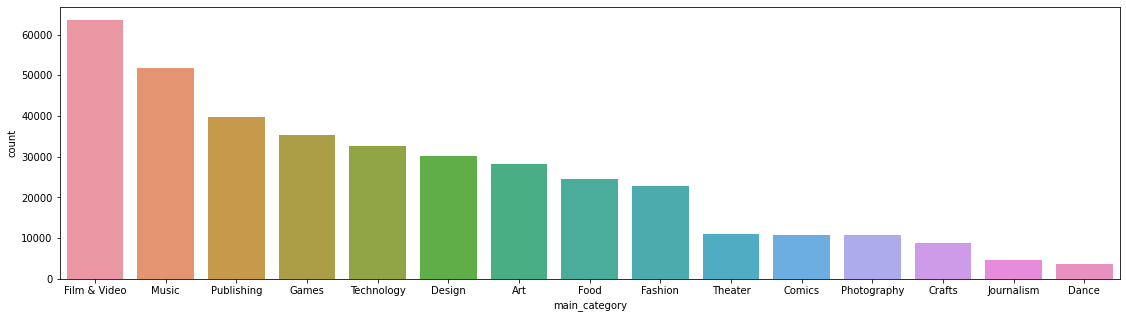

In [ ]:
plt.subplots(figsize=(19,5))
sns.countplot(x='main_category',data=data,order=data['main_category'].value_counts().index)

*Número de proyectos por año*

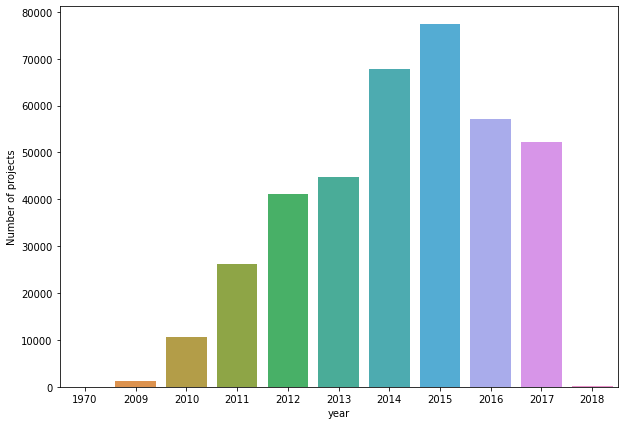

In [ ]:
plt.subplots(figsize=(10,7))
sns.countplot(data['year'])
plt.ylabel("Number of projects")
plt.show()

### Eliminacion de variables y registros

Se eliminarán los proyectos que no están dentro de la categoría de existosos o no exitosos

In [ ]:
data = data[data['state'].isin(['successful','failed'])]

In [ ]:
data.shape

(331675, 13)

Se obtendrá un dataset en el que las variables categóricas estén representadas numéricamente

In [ ]:
data_categorical = data.copy()

In [ ]:
data.head()

,category,main_category,currency,state,country,usd_goal_real,start_day,end_day,start_month,end_month,year,name_length,campaign_length
0,Poetry,Publishing,GBP,failed,GB,1533.95,1,4,8,10,2015,31.0,58.491343
1,Narrative Film,Film & Video,USD,failed,US,30000.00,5,2,9,11,2017,45.0,59.802813
2,Narrative Film,Film & Video,USD,failed,US,45000.00,5,1,1,2,2013,14.0,44.985532
3,Music,Music,USD,failed,US,5000.00,5,0,3,4,2012,49.0,29.858206
5,Restaurants,Food,USD,successful,US,50000.00,4,4,2,4,2016,20.0,34.431632


In [ ]:
encodings = {}
categorical_variables = ['category','main_category','currency','country','state','year']
for cat in categorical_variables:
  data_categorical[cat] = encoder.fit_transform(data_categorical[cat].astype(str))
  encodings[cat] = dict(zip(encoder.classes_,encoder.transform(encoder.classes_)))

In [ ]:
encodings['state']

{'failed': 0, 'successful': 1}

In [ ]:
data_categorical['state'].value_counts()

0    197719
1    133956
Name: state, dtype: int64

In [ ]:
data.shape

(331675, 13)

In [ ]:
data_categorical.shape

(331675, 13)

In [ ]:
data.isnull().sum()

category           0
main_category      0
currency           0
state              0
country            0
usd_goal_real      0
start_day          0
end_day            0
start_month        0
end_month          0
year               0
name_length        3
campaign_length    0
dtype: int64

In [ ]:
# Eliminar los valores no dispoibles sustituyéndolos con el promedio
data['name_length'] = data['name_length'].fillna(value=data['name_length'].mean())

In [ ]:
data.isnull().sum()

category           0
main_category      0
currency           0
state              0
country            0
usd_goal_real      0
start_day          0
end_day            0
start_month        0
end_month          0
year               0
name_length        0
campaign_length    0
dtype: int64

In [ ]:
print(data.shape)
print(data_categorical.shape)

(331675, 13)
(331675, 13)


### Analisis descriptivo de los datos

**c. Realizar un análisis descriptivo (numérico y gráfico) de los datos, tomando en cuenta el tipo de variable en cuestión.**

Descripción de las variables numéricas (usd_goal_real, name_length,campaign_length) y las categóricas

Para las 3 variables numéricas se les aplicaron análisis descriptivos y se observó que la variable usd_goal_real estaban en rangos muy amplios asi cono que campaign length estaba sesgada, por lo que se decidió aplicar transformaciones (ver Transformación de los datos)

In [ ]:
numeric_vars = data_categorical[['usd_goal_real','name_length','campaign_length']]
categorical_vars = data_categorical[['category','main_category','currency','state','country','start_day','end_day','start_month','end_month','year']]

In [ ]:
numeric_vars.describe()

,usd_goal_real,name_length,campaign_length
count,3.316750e+05,331672.000000,331675.000000
mean,4.151000e+04,34.220335,33.389378
std,1.108930e+06,15.961502,12.723385
min,1.000000e-02,1.000000,0.005058
25%,2.000000e+03,21.000000,29.088929
50%,5.000000e+03,33.000000,29.656759
75%,1.500000e+04,48.000000,35.705966
max,1.663614e+08,85.000000,91.962650


usd_goal_real         AxesSubplot(0.125,0.71587;0.168478x0.16413)
name_length        AxesSubplot(0.327174,0.71587;0.168478x0.16413)
campaign_length    AxesSubplot(0.529348,0.71587;0.168478x0.16413)
dtype: object

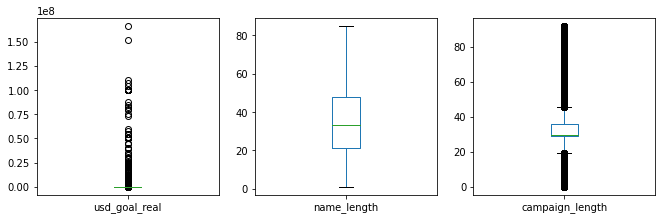

In [ ]:
numeric_vars.plot(kind='box',subplots=True, figsize=(15,15),layout=(4,4),)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2235a5c828>,
      dtype=object)

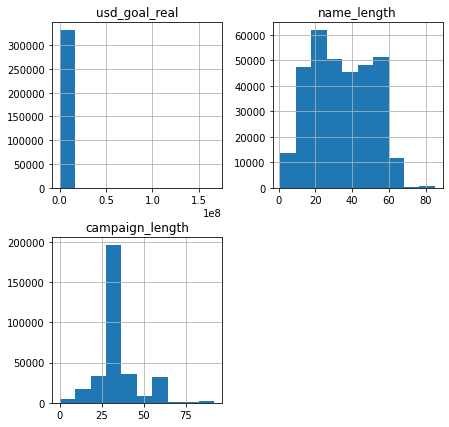

In [ ]:
numeric_vars.hist(figsize=(7,7))

Para las 10 variables categóricas, en primera instancia les aplicamos encoding para poder hacer análisis descriptivos. Como se puede ver las únicas variables que presentan outliers son las de country y currency. Aquí podemos ver su distribución y posteriormente a estas variables se les aplicó one hot enoding por lo que terminaron siendo  0 y 1 s. 

In [ ]:
categorical_vars.describe()

,category,main_category,currency,state,country,start_day,end_day,start_month,end_month,year
count,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000
mean,80.292557,7.483410,11.081227,0.403877,18.994826,2.421826,3.183773,6.416163,6.758483,5.180002
std,45.069033,3.931466,3.878572,0.490674,6.193821,1.762946,1.951072,3.306989,3.315202,1.930922
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,39.000000,5.000000,13.000000,0.000000,22.000000,1.000000,2.000000,4.000000,4.000000,4.000000
50%,85.000000,7.000000,13.000000,0.000000,22.000000,2.000000,3.000000,6.000000,7.000000,5.000000
75%,119.000000,10.000000,13.000000,1.000000,22.000000,4.000000,5.000000,9.000000,10.000000,7.000000
max,158.000000,14.000000,13.000000,1.000000,22.000000,6.000000,6.000000,12.000000,12.000000,8.000000


category            AxesSubplot(0.125,0.749828;0.133621x0.130172)
main_category    AxesSubplot(0.285345,0.749828;0.133621x0.130172)
currency          AxesSubplot(0.44569,0.749828;0.133621x0.130172)
state            AxesSubplot(0.606034,0.749828;0.133621x0.130172)
country          AxesSubplot(0.766379,0.749828;0.133621x0.130172)
start_day           AxesSubplot(0.125,0.593621;0.133621x0.130172)
end_day          AxesSubplot(0.285345,0.593621;0.133621x0.130172)
start_month       AxesSubplot(0.44569,0.593621;0.133621x0.130172)
end_month        AxesSubplot(0.606034,0.593621;0.133621x0.130172)
year             AxesSubplot(0.766379,0.593621;0.133621x0.130172)
dtype: object

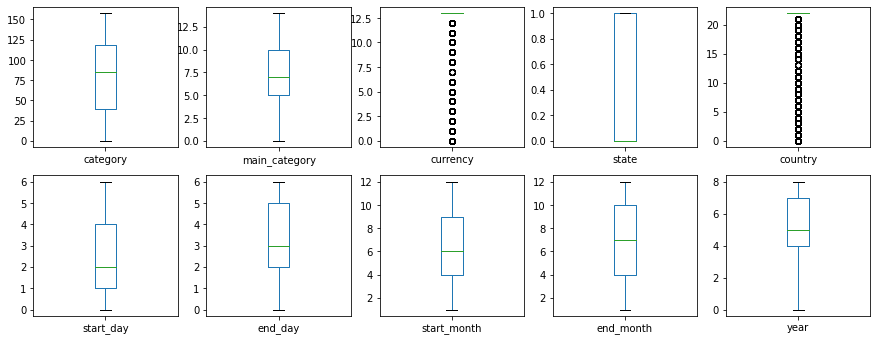

In [ ]:
categorical_vars.plot(kind='box',subplots=True, figsize=(15,15),layout=(5,5),)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f223518e080>,
      dtype=object)

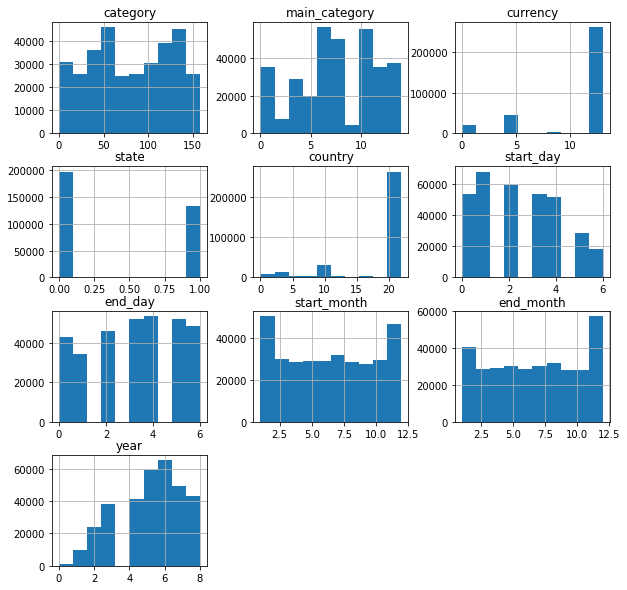

In [ ]:
categorical_vars.hist(figsize=(10,10))

### Transformacion de los datos

**d. Determinar en cuáles factores (continuos, discretos, categóricos, binarios, etc.) sería
conveniente realizar algún tipo de transformación. En los casos que así lo consideres
adecuado, indicar y realizar dichas transformaciones.**

Las variables numéricas se deben de transformar puesto que tienen un rango muy amplio en el caso de usd y presentan sesgo

In [ ]:
data_categorical.head()

,category,main_category,currency,state,country,usd_goal_real,start_day,end_day,start_month,end_month,year,name_length,campaign_length
0,108,12,5,0,9,1533.95,1,4,8,10,6,31.0,58.491343
1,93,6,13,0,22,30000.00,5,2,9,11,8,45.0,59.802813
2,93,6,13,0,22,45000.00,5,1,1,2,4,14.0,44.985532
3,90,10,13,0,22,5000.00,5,0,3,4,3,49.0,29.858206
5,123,7,13,1,22,50000.00,4,4,2,4,7,20.0,34.431632


In [ ]:
data_categorical.shape

(331675, 13)

In [ ]:
data_trans = data.copy()

In [ ]:
data_trans['usd_goal_real'] = np.log(data_trans['usd_goal_real']+(1-data_trans['usd_goal_real'].min()))
#data_trans['usd_goal_real'] = np.power(data_trans['usd_goal_real'],1/4)
#data_trans['usd_pledged_real'] = np.log(data_trans['usd_pledged_real']+(1-data_trans['usd_pledged_real'].min()))
#data_trans['campaign_length'] = np.log(data_trans['campaign_length'] +(1-data_trans['campaign_length'].min()))
#data_trans['campaign_length'] = (data_trans['campaign_length'] - data_trans['campaign_length'].mean())/data_trans['campaign_length'].std()
data_trans['campaign_length'] = np.power(data_trans['campaign_length'],1/2)
#data_trans['campaign_length'] = (data_trans['campaign_length'] - data_trans['campaign_length'].min())/(data_trans['campaign_length'].max() - data_trans['campaign_length'].min())
#data_trans['country'] = np.power((data_trans['country'].max()+5)-data_trans['campaign_length'],1/2)
# data_trans['country'] = np.log(data_trans['country'])


In [ ]:
data_categorical['usd_goal_real'] = np.log(data_categorical['usd_goal_real']+(1-data_categorical['usd_goal_real'].min()))
#data_categorical['usd_pledged_real'] = np.log(data_categorical['usd_pledged_real']+(1-data_categorical['usd_pledged_real'].min()))
data_categorical['campaign_length'] = np.power(data_categorical['campaign_length'],1/2)

In [ ]:
data_categorical.head()

,category,main_category,currency,state,country,usd_goal_real,start_day,end_day,start_month,end_month,year,name_length,campaign_length
0,108,12,5,0,9,7.336247,1,4,8,10,6,31.0,7.647963
1,93,6,13,0,22,10.308986,5,2,9,11,8,45.0,7.733228
2,93,6,13,0,22,10.714440,5,1,1,2,4,14.0,6.707125
3,90,10,13,0,22,8.517391,5,0,3,4,3,49.0,5.464266
5,123,7,13,1,22,10.819798,4,4,2,4,7,20.0,5.867847


In [ ]:
data_trans.head()

,category,main_category,currency,state,country,usd_goal_real,start_day,end_day,start_month,end_month,year,name_length,campaign_length
0,Poetry,Publishing,GBP,failed,GB,7.336247,1,4,8,10,2015,31.0,7.647963
1,Narrative Film,Film & Video,USD,failed,US,10.308986,5,2,9,11,2017,45.0,7.733228
2,Narrative Film,Film & Video,USD,failed,US,10.714440,5,1,1,2,2013,14.0,6.707125
3,Music,Music,USD,failed,US,8.517391,5,0,3,4,2012,49.0,5.464266
5,Restaurants,Food,USD,successful,US,10.819798,4,4,2,4,2016,20.0,5.867847


In [ ]:
#numeric_vars_trans = data_trans[['usd_pledged_real','usd_goal_real','name_length','campaign_length']]
numeric_vars_trans = data_trans[['usd_goal_real','name_length','campaign_length']]
categorical_vars_trans = data_trans[['category','main_category','currency','state','country','start_day','end_day','start_month','end_month','year']]

In [ ]:
numeric_vars_trans.describe()

,usd_goal_real,name_length,campaign_length
count,331675.000000,331675.000000,331675.000000
mean,8.582612,34.220335,5.678290
std,1.667154,15.961430,1.070703
min,0.000000,1.000000,0.071119
25%,7.601397,21.000000,5.393415
50%,8.517391,33.000000,5.445802
75%,9.615871,48.000000,5.975447
max,18.929673,85.000000,9.589716


usd_goal_real         AxesSubplot(0.125,0.71587;0.168478x0.16413)
name_length        AxesSubplot(0.327174,0.71587;0.168478x0.16413)
campaign_length    AxesSubplot(0.529348,0.71587;0.168478x0.16413)
dtype: object

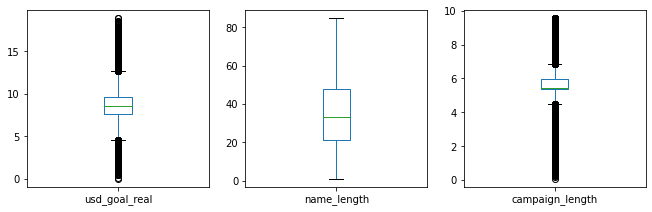

In [ ]:
numeric_vars_trans.plot(kind='box',subplots=True, figsize=(15,15),layout=(4,4),)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2234897710>,
      dtype=object)

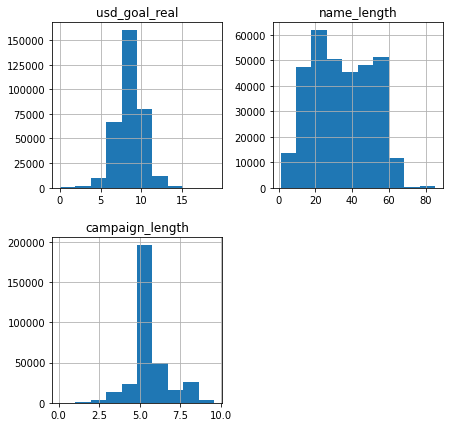

In [ ]:
numeric_vars_trans.hist(figsize=(7,7))

**e. Determina si existe algún tipo de correlación entre algunos factores que consideres pueda
darte información relevante para el diseño posterior del modelo a buscar.**

In [ ]:
data_categorical.corr()

,category,main_category,currency,state,country,usd_goal_real,start_day,end_day,start_month,end_month,year,name_length,campaign_length
category,1.000000,0.199748,-0.009132,0.033861,-0.009640,0.039007,-0.003825,-0.000098,-0.003025,-0.007431,-0.045255,-0.009044,-0.003879
main_category,0.199748,1.000000,-0.011872,-0.032147,-0.010828,0.087050,0.003887,0.007080,0.000148,-0.005072,-0.018734,0.054670,0.041085
currency,-0.009132,-0.011872,1.000000,0.059021,0.985873,0.004756,0.004205,-0.002937,-0.025864,-0.020896,-0.280509,0.022399,0.026284
state,0.033861,-0.032147,0.059021,1.000000,0.054805,-0.224577,-0.020739,-0.022397,-0.010488,-0.001867,-0.073835,0.104365,-0.117321
country,-0.009640,-0.010828,0.985873,0.054805,1.000000,0.006781,0.003137,-0.002808,-0.024338,-0.019959,-0.274303,0.021020,0.027274
usd_goal_real,0.039007,0.087050,0.004756,-0.224577,0.006781,1.000000,-0.029878,0.012179,0.015163,0.017244,0.056422,0.042964,0.211300
start_day,-0.003825,0.003887,0.004205,-0.020739,0.003137,-0.029878,1.000000,-0.028488,-0.017933,-0.019954,-0.033490,-0.007881,0.020077
end_day,-0.000098,0.007080,-0.002937,-0.022397,-0.002808,0.012179,-0.028488,1.000000,-0.000149,-0.001993,0.001237,-0.013638,0.010381
start_month,-0.003025,0.000148,-0.025864,-0.010488,-0.024338,0.015163,-0.017933,-0.000149,1.000000,0.612907,-0.091069,0.015149,-0.015355
end_month,-0.007431,-0.005072,-0.020896,-0.001867,-0.019959,0.017244,-0.019954,-0.001993,0.612907,1.000000,-0.015546,0.019106,-0.022633


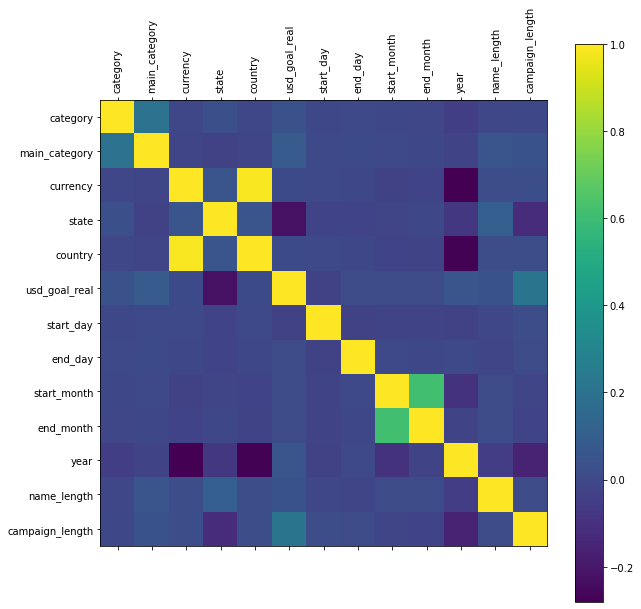

In [ ]:
f = plt.figure(figsize=(10,10))
plt.matshow(data_categorical.corr(), fignum=f.number)
plt.xticks(range(data_categorical.shape[1]),data_categorical.columns, rotation=90)
plt.yticks(range(data_categorical.shape[1]),data_categorical.columns)
cb = plt.colorbar()
plt.show()

Se observó que 'country' y 'currency' aportaban la misma información así que se eliminó currency

In [ ]:
data_categorical = data.drop(['currency'],axis=1)
data_trans = data_trans.drop(['currency'],axis=1)

In [ ]:
print(data_categorical.shape)
print(data_trans.shape)

(331675, 12)
(331675, 12)


**f. Realiza un análisis para identificación de valores extremos (outliers). Indicar la cantidad de
ellos en cada variable y la decisión que tomaras al respecto para su tratamiento en la
solución del problema.**

In [ ]:
q1 = data_categorical.quantile(0.25)
q3 = data_categorical.quantile(0.75)
iqr = q3 - q1


#((data_trans < (q1 - iqr)) | (data_trans > (q3 + iqr))).sum()
((((data_categorical < q1 -1.5 * iqr) | (data_categorical > q3 + 1.5 * iqr)).sum())/len(data_categorical)*100)

campaign_length    21.097761
category            0.000000
country             0.000000
end_day             0.000000
end_month           0.000000
main_category       0.000000
name_length         0.000000
start_day           0.000000
start_month         0.000000
state               0.000000
usd_goal_real      11.773272
year                0.000000
dtype: float64

**Deberás utilizar 5 algoritmos diferentes de aprendizaje automático. Tres de ellos deberán ser Red Neuronal Multicapa (MLP), Máquina de Vectores de Soporte (SVM) y Random Forest
(RF). Los otros dos pueden ser algunos de los siguientes:
i. Regresión Logística / Lineal / Polinomial.
ii. k-Vecinos Más Cercanos (kNN).
iii. Máquinas de Vectores de Soporte de Base Radial (SVM-RBF).
iv. Bayes Ingenuo / Bayes Ingenuo Gaussiano.
v. Árbol de Decisiones.
vi. Si lo consideras adecuado puedes proponer alguna variante de los modelos
anteriores o inclusive algún otro no incluido. Igualmente puedes usar alguno de los modelos conjuntos (ensemble learning) aplicado a algunos de ellos.**

**Cada uno de los 5 modelos seleccionados deberás realizarlos con las siguientes
características:**


1.   Realizar una partición del conjunto original de datos en 3 conjuntos: Entrenamiento,
Validación y Prueba. NOTA: Si decides estar aplicando Validación Cruzada (CV), en
este paso deberás entonces realizar solamente una partición en un conjunto de
Entrenamiento y uno de Prueba. Deberás justificar el porcentaje de las particiones a
utilizar. Deberás utilizar la misma partición en todos los casos.
2.   Realiza el entrenamiento en el conjunto de prueba y reportando las métricas
obtenidas en el conjunto de validación. NOTA: En dado caso aquí podrías estar
usando Cross-Validation si así lo consideras adecuado.
iii. Indicar las métricas que estarás utilizando. Por ejemplo: accuracy, recall, SSE, etc. Si
el problema es de clasificación, incluir además la matriz de confusión.
3. Indicar las métricas que estarás utilizando. Por ejemplo: accuracy, recall, SSE, etc. Si
el problema es de clasificación, incluir además la matriz de confusión.
4. En cada uno de los modelos utilizados especifica los parámetros óptimos
encontrados para el mejor resultado de cada caso. Puedes hacer la búsqueda manual
o apoyarte en las clases RandomizedSearchCV y/o GridSearchCV de sklearn.

### **Partición conjunto de datos**

In [ ]:
data_trans.shape

(331675, 12)

In [ ]:
data_trans.head()

,category,main_category,state,country,usd_goal_real,start_day,end_day,start_month,end_month,year,name_length,campaign_length
0,Poetry,Publishing,failed,GB,7.336247,1,4,8,10,2015,31.0,7.647963
1,Narrative Film,Film & Video,failed,US,10.308986,5,2,9,11,2017,45.0,7.733228
2,Narrative Film,Film & Video,failed,US,10.714440,5,1,1,2,2013,14.0,6.707125
3,Music,Music,failed,US,8.517391,5,0,3,4,2012,49.0,5.464266
5,Restaurants,Food,successful,US,10.819798,4,4,2,4,2016,20.0,5.867847


In [ ]:
data_trans.describe()

,usd_goal_real,start_day,end_day,start_month,end_month,year,name_length,campaign_length
count,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000
mean,8.582612,2.421826,3.183773,6.416163,6.758483,2014.180002,34.220335,5.678290
std,1.667154,1.762946,1.951072,3.306989,3.315202,1.930922,15.961430,1.070703
min,0.000000,0.000000,0.000000,1.000000,1.000000,2009.000000,1.000000,0.071119
25%,7.601397,1.000000,2.000000,4.000000,4.000000,2013.000000,21.000000,5.393415
50%,8.517391,2.000000,3.000000,6.000000,7.000000,2014.000000,33.000000,5.445802
75%,9.615871,4.000000,5.000000,9.000000,10.000000,2016.000000,48.000000,5.975447
max,18.929673,6.000000,6.000000,12.000000,12.000000,2017.000000,85.000000,9.589716


In [ ]:
data_trans.dtypes

category            object
main_category       object
state               object
country             object
usd_goal_real      float64
start_day            int64
end_day              int64
start_month          int64
end_month            int64
year                 int64
name_length        float64
campaign_length    float64
dtype: object

Se va a obtener un dataset que tenga las variables categóricas independeintes en one hot encoding. Hay 11 variables independientes, de las cuales 8 son categóricas. En la tabla de abajo se ve cuántas categorías hay de cada una. 

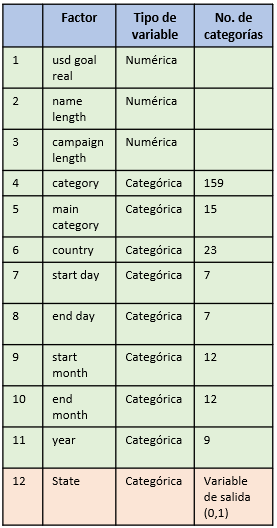

In [ ]:
data_for_model = pd.get_dummies(data_trans, columns=['category','main_category','country','start_day','end_day','start_month','end_month','year'])
data_for_model['state'] =  encoder.fit_transform(data_categorical['state'].astype(str))
data_for_model[['state','usd_goal_real','name_length','campaign_length']].describe()

,state,usd_goal_real,name_length,campaign_length
count,331675.000000,331675.000000,331675.000000,331675.000000
mean,0.403877,8.582612,34.220335,5.678290
std,0.490674,1.667154,15.961430,1.070703
min,0.000000,0.000000,1.000000,0.071119
25%,0.000000,7.601397,21.000000,5.393415
50%,0.000000,8.517391,33.000000,5.445802
75%,1.000000,9.615871,48.000000,5.975447
max,1.000000,18.929673,85.000000,9.589716


Al sumar el número de categorías más las variables numéricas y la variable de salida, obtenemos que las columnas en el datframe con one hot encoding es de 248

In [ ]:
data_for_model.shape

(331675, 248)

In [ ]:
data_for_model.head()

,state,usd_goal_real,name_length,campaign_length,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Couture,category_Crafts,category_Crochet,category_DIY,category_DIY Electronics,...,end_day_0,end_day_1,end_day_2,end_day_3,end_day_4,end_day_5,end_day_6,start_month_1,start_month_2,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9,start_month_10,start_month_11,start_month_12,end_month_1,end_month_2,end_month_3,end_month_4,end_month_5,end_month_6,end_month_7,end_month_8,end_month_9,end_month_10,end_month_11,end_month_12,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017
0,0,7.336247,31.0,7.647963,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0,10.308986,45.0,7.733228,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,0,10.714440,14.0,6.707125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,8.517391,49.0,5.464266,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,1,10.819798,20.0,5.867847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Problema de regresión
#x = data_trans[['category', 'main_category', 'currency', 'country','usd_goal_real', 'start_day', 'end_day', 'start_month', 'end_month','name_length', 'campaign_length']]
#y = data_trans['usd_pledged_real']

#Problema de clasificación
#x = data_trans[['category', 'main_category', 'currency', 'country','usd_goal_real', 'start_day', 'end_day', 'start_month', 'end_month','name_length', 'campaign_length']]
#y = data_trans['state']     
x = data_for_model.iloc[:,data_for_model.columns != 'state']
# x = x.drop(['usd_pledged_real'], axis=1)
y = data_for_model.state

In [ ]:
print("X shape: ", x.shape)
print("Y shape: ", y.shape)

X shape:  (331675, 247)
Y shape:  (331675,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [ ]:
print("X train: ", x_train.shape)
print("X val: ", x_val.shape)
print("X test: ", x_test.shape)
print()
print("Y train: ", y_train.shape)
print("Y val: ", y_val.shape)
print("Y test: ", y_test.shape)

X train:  (265340, 247)
X val:  (33168, 247)
X test:  (33167, 247)

Y train:  (265340,)
Y val:  (33168,)
Y test:  (33167,)


In [ ]:
x_train.head()

,usd_goal_real,name_length,campaign_length,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Couture,category_Crafts,category_Crochet,category_DIY,category_DIY Electronics,category_Dance,...,end_day_0,end_day_1,end_day_2,end_day_3,end_day_4,end_day_5,end_day_6,start_month_1,start_month_2,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9,start_month_10,start_month_11,start_month_12,end_month_1,end_month_2,end_month_3,end_month_4,end_month_5,end_month_6,end_month_7,end_month_8,end_month_9,end_month_10,end_month_11,end_month_12,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017
103081,6.685848,56.0,5.389145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
135088,10.351276,42.0,5.448164,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
38454,8.294297,11.0,5.912576,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
146953,8.294297,58.0,5.889598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
34820,9.058422,21.0,5.597628,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
scaler = preprocessing.MinMaxScaler((0,1))
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)
x_val_scaled = scaler.fit_transform(x_val)

## Analisis de modelos

### **Perceptrón Multipcapa**

*First approach*

In [ ]:
def build_mlp_model(hidden_layers = [6, 2], dropout_rate = 0, add_bn = True, l2_penalty = 0, optimizer = 'adam'):
    mlp_model = Sequential()
    mlp_model.add(Dense(input_shape=(x_train_scaled.shape[1],),units=10, activation='relu'))
    for layer in hidden_layers:       
        mlp_model.add(Dense(layer, kernel_regularizer = l2(l2_penalty), activation='relu'))
        if add_bn:
            mlp_model.add(BatchNormalization())       
        if dropout_rate:
            mlp_model.add(Dropout(dropout_rate))

    mlp_model.add(Dense(1, activation='sigmoid'))
    mlp_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return mlp_model

In [ ]:
mlp_model = KerasClassifier(build_mlp_model)
mlp_model.fit(x_train_scaled, y_train, batch_size=100, epochs=10, verbose=1)

Epoch 1/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.6349 - accuracy: 0.6478
Epoch 2/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.5927 - accuracy: 0.6769
Epoch 3/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.5890 - accuracy: 0.6795
Epoch 4/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.5860 - accuracy: 0.6817
Epoch 5/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.5840 - accuracy: 0.6845
Epoch 6/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.5821 - accuracy: 0.6856
Epoch 7/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.5812 - accuracy: 0.6859
Epoch 8/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.5801 - accuracy: 0.6867
Epoch 9/10
2654/2654 [==============================] - 13s 5ms/step - loss: 0.5792 - accuracy: 0.6875
Epoch 10/10
2654/2654 [==============================] - 12s 5ms/step - l

In [ ]:
y_mlp_pred = mlp_model.predict(x_val_scaled, batch_size=10)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
y_mlp_pred = y_mlp_pred >0.5

In [ ]:
accuracy_score(y_val, y_mlp_pred)

0.6892185238784371

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_mlp_pred > 0.5))

              precision    recall  f1-score   support

           0       0.72      0.79      0.75     19898
           1       0.63      0.53      0.58     13270

    accuracy                           0.69     33168
   macro avg       0.68      0.66      0.67     33168
weighted avg       0.68      0.69      0.68     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_mlp_pred)

array([[15761,  4137],
       [ 6171,  7099]])

*With RandomizedSearchCV*

In [ ]:
dropout_rate_opts  = [0, 0.2, 0.5]
hidden_layers_opts = [(6, 6, 2), (64, 32, 8, 2), (32, 32, 32, 2)]
l2_penalty_opts = [0.01, 0.1, 0.5]
add_bn_opts = [False, True]
optimizer_opts = ['adam', 'adagrad', 'rmsprop']

mlp_grid = {
    'hidden_layers': hidden_layers_opts,
    'dropout_rate': dropout_rate_opts,  
    'l2_penalty': l2_penalty_opts,
    'add_bn': add_bn_opts,
    'optimizer': optimizer_opts
}

mlp_model = KerasClassifier(build_fn=build_mlp_model, epochs=10, batch_size=100, verbose=0)
mlp_randomized = RandomizedSearchCV(estimator=mlp_model, param_distributions=mlp_grid, n_iter=10, scoring='accuracy')
mlp_randomized.fit(x_train_scaled, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f21d3771fd0>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'add_bn': [False, True],
                                        'dropout_rate': [0, 0.2, 0.5],
                                        'hidden_layers': [(6, 6, 2),
                                                          (64, 32, 8, 2),
                                                          (32, 32, 32, 2)],
                                        'l2_penalty': [0.01, 0.1, 0.5],
                                        'optimizer': ['adam', 'adagrad',
                                                      'rmsprop']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=0)

In [ ]:
mlp_randomized.best_estimator_

In [ ]:
mlp_randomized.best_params_

{'add_bn': True,
 'dropout_rate': 0,
 'hidden_layers': (32, 32, 32, 2),
 'l2_penalty': 0.01,
 'optimizer': 'adam'}

In [ ]:
mlp_randomized.best_score_

0.6758234717720659

In [ ]:
y_mlp_pred_random = mlp_randomized.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_mlp_pred_random)

0.6798721659430776

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_mlp_pred_random))

              precision    recall  f1-score   support

           0       0.68      0.87      0.77     19898
           1       0.67      0.40      0.50     13270

    accuracy                           0.68     33168
   macro avg       0.68      0.63      0.63     33168
weighted avg       0.68      0.68      0.66     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_mlp_pred_random)

array([[17288,  2610],
       [ 8008,  5262]])

### Regresión Logística

*First approach*

In [ ]:
logistic_model = LogisticRegression(max_iter=150, solver='sag')
logistic_model.fit(x_train_scaled, y_train)
y_logistic_pred = logistic_model.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_logistic_pred)

0.6819826338639653

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_logistic_pred))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75     19898
           1       0.62      0.52      0.57     13270

    accuracy                           0.68     33168
   macro avg       0.67      0.66      0.66     33168
weighted avg       0.68      0.68      0.68     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_logistic_pred)

array([[15716,  4182],
       [ 6366,  6904]])

*With RandomizedSearchCV*

In [ ]:
penalty = ['l2',None]
c_val = [10**i for i in range(-2,2,1)]
solver = ['lbfgs','sag','saga']
iterations = [150,200]

lr_grid = {'C': c_val,
           'penalty':penalty,
           'solver': solver,
           'max_iter':iterations
}

base_model = LogisticRegression()
logistic_randomized = RandomizedSearchCV(estimator=base_model, param_distributions=lr_grid, n_iter=10, scoring='accuracy')
logistic_randomized.fit(x_train_scaled, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'max_iter': [150, 200],
                                        'penalty': ['l2', None],
                                        'solver': ['lbfgs', 'sag', 'saga']},
       

In [ ]:
logistic_randomized.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=150,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
logistic_randomized.best_params_

{'C': 0.1, 'max_iter': 150, 'penalty': 'l2', 'solver': 'lbfgs'}

In [ ]:
logistic_randomized.best_score_

0.6784842089394738

In [ ]:
y_logistic_pred_random = logistic_randomized.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_logistic_pred_random)

0.6818921852387844

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_logistic_pred_random))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75     19898
           1       0.62      0.52      0.57     13270

    accuracy                           0.68     33168
   macro avg       0.67      0.65      0.66     33168
weighted avg       0.68      0.68      0.68     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_logistic_pred_random)

array([[15753,  4145],
       [ 6406,  6864]])

### **Random Forest**

*First approach*

In [ ]:
rf_model = RandomForestClassifier(n_estimators=150,random_state=431,max_depth=6)
rf_model.fit(x_train_scaled,y_train)
y_rf_pred = rf_model.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_rf_pred)

0.6277436082971539

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_rf_pred))

              precision    recall  f1-score   support

           0       0.62      0.97      0.76     19898
           1       0.71      0.12      0.20     13270

    accuracy                           0.63     33168
   macro avg       0.66      0.54      0.48     33168
weighted avg       0.66      0.63      0.54     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_rf_pred)

array([[19238,   660],
       [11687,  1583]])

*With RandomizedSearchCV*

In [ ]:
n_estimators = [100,120,150]
criterion = ["gini","entropy"]
max_depth = list(range(1,7))
boot_strap = [True,False]
oob_score = [True,False]
ccp_values_small = [10**i for i in range(-3, 0)]
ccp_values_medium = [0.10 * i for i in range(0,3,4)]
ccp_alpha = ccp_values_small + ccp_values_medium + [1,5,10]
random_state = [431]

random_grid = {"n_estimators": n_estimators,
               "criterion":criterion,
               "max_depth": max_depth,
               "bootstrap": boot_strap,
               "oob_score": oob_score,
               "ccp_alpha":ccp_alpha,
               "random_state": random_state
               }


In [ ]:
rf_randomized_model = RandomForestClassifier()
rf_randomized = RandomizedSearchCV(estimator=rf_randomized_model, param_distributions=random_grid, n_iter=5, scoring='accuracy')
rf_randomized.fit(x_train_scaled, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [ ]:
rf_randomized.best_params_

{'bootstrap': True,
 'ccp_alpha': 0.01,
 'criterion': 'entropy',
 'max_depth': 2,
 'n_estimators': 150,
 'oob_score': False,
 'random_state': 431}

In [ ]:
rf_randomized.best_score_

0.5956169442978819

In [ ]:
y_pred_rf_randomized = rf_randomized.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_pred_rf_randomized)

0.5999155812831645

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_pred_rf_randomized))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75     19898
           1       0.00      0.00      0.00     13270

    accuracy                           0.60     33168
   macro avg       0.30      0.50      0.37     33168
weighted avg       0.36      0.60      0.45     33168



In [ ]:
print(confusion_matrix(y_true=y_val,y_pred=y_pred_rf_randomized))

[[19898     0]
 [13270     0]]


### **Decision Tree**

*First Approach*

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train_scaled, y_train)
y_dt_pred = dt_model.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_dt_pred)

0.5949107573564881

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_dt_pred))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65     19898
           1       0.49      0.53      0.51     13270

    accuracy                           0.59     33168
   macro avg       0.58      0.58      0.58     33168
weighted avg       0.60      0.59      0.60     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_dt_pred)

array([[12658,  7240],
       [ 6196,  7074]])

*With RandomizedSearchCV*

In [ ]:
ccp_values_small = [10**i for i in range(-4,-1)]
ccp_values_large = [0.10 * i for i in range(1,10)]
ccp_vals = ccp_values_small + ccp_values_large + [1,5,10]
criteria = ['gini','entropy']
max_length = list(range(1,7,1))
min_samples_split = list(range(2,7,1))
min_samples_leaf = list(range(1,7,1))

random_grid_tree = {"criterion":criteria,
                    "max_depth": max_length,
                    "min_samples_split": min_samples_split,
                    "min_samples_leaf": min_samples_leaf,
                    "ccp_alpha": ccp_vals
                    }

In [ ]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_randomized = RandomizedSearchCV(estimator=decision_tree_model, param_distributions=random_grid_tree, n_iter=10, scoring='accuracy')
decision_tree_randomized.fit(x_train_scaled, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
       

In [ ]:
y_dt_pred_randomized = decision_tree_randomized.predict(x_val_scaled)

In [ ]:
decision_tree_randomized.best_params_

{'ccp_alpha': 0.01,
 'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 5,
 'min_samples_split': 4}

In [ ]:
decision_tree_randomized.best_score_

0.5956169442978819

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_dt_pred_randomized)

0.5999155812831645

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_dt_pred_randomized))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75     19898
           1       0.00      0.00      0.00     13270

    accuracy                           0.60     33168
   macro avg       0.30      0.50      0.37     33168
weighted avg       0.36      0.60      0.45     33168



In [ ]:
confusion_matrix(y_true=y_val,y_pred=y_dt_pred_randomized)

array([[19898,     0],
       [13270,     0]])

### SVM

*First approach*

In [ ]:
svc_model = SVC(kernel="linear", C=0.1, max_iter=1000)
svc_model.fit(x_train_scaled, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_svc_pred = svc_model.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_svc_pred)

0.5768813314037626

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_svc_pred))

              precision    recall  f1-score   support

           0       0.64      0.67      0.66     19898
           1       0.47      0.44      0.45     13270

    accuracy                           0.58     33168
   macro avg       0.55      0.55      0.55     33168
weighted avg       0.57      0.58      0.57     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_svc_pred)

array([[13346,  6552],
       [ 7482,  5788]])

*Second approach*

In [ ]:
svc_model = SVC(kernel="rbf", C=0.1, max_iter=1000)
svc_model.fit(x_train_scaled, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_svc_pred = svc_model.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_svc_pred)

0.58634828750603

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_svc_pred))

              precision    recall  f1-score   support

           0       0.60      0.90      0.72     19898
           1       0.43      0.11      0.18     13270

    accuracy                           0.59     33168
   macro avg       0.52      0.51      0.45     33168
weighted avg       0.54      0.59      0.51     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_svc_pred)

array([[17970,  1928],
       [11792,  1478]])

## Prueba del mejor modelo

In [ ]:
mlp_model = build_mlp_model()
mlp_model.fit(x_train_scaled, y_train, batch_size=100, epochs=10, verbose=1)

Epoch 1/10
2654/2654 [==============================] - 13s 5ms/step - loss: 0.6346 - accuracy: 0.6393
Epoch 2/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.5931 - accuracy: 0.6758
Epoch 3/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.5897 - accuracy: 0.6790
Epoch 4/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.5878 - accuracy: 0.6814
Epoch 5/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.5860 - accuracy: 0.6824
Epoch 6/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.5847 - accuracy: 0.6830
Epoch 7/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.5833 - accuracy: 0.6851
Epoch 8/10
2654/2654 [==============================] - 13s 5ms/step - loss: 0.5824 - accuracy: 0.6858
Epoch 9/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.5816 - accuracy: 0.6856
Epoch 10/10
2654/2654 [==============================] - 12s 5ms/step - l

In [ ]:
y_pred = mlp_model.predict(x_test_scaled, batch_size=10)

In [ ]:
y_pred = y_pred >0.5

In [ ]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.682968010371755

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74     19780
           1       0.61      0.58      0.60     13387

    accuracy                           0.68     33167
   macro avg       0.67      0.67      0.67     33167
weighted avg       0.68      0.68      0.68     33167



In [ ]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[14906,  4874],
       [ 5641,  7746]])

In [ ]:
mlp_model.summary()

Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_653 (Dense)            (None, 10)                2480      
_________________________________________________________________
dense_654 (Dense)            (None, 6)                 66        
_________________________________________________________________
batch_normalization_127 (Bat (None, 6)                 24        
_________________________________________________________________
dense_655 (Dense)            (None, 2)                 14        
_________________________________________________________________
batch_normalization_128 (Bat (None, 2)                 8         
_________________________________________________________________
dense_656 (Dense)            (None, 1)                 3         
Total params: 2,595
Trainable params: 2,579
Non-trainable params: 16
_________________________________________________

## Post procesamiento de datos

Debido a los resultados poco exitosos que obtuvimos de los modelos hicimos un segundo analisis de las variables utilizadas usando el modelo de regresion lineal por minimos cuadrados para obtener los p-values.

In [ ]:
x_train_scaled_const = sm.add_constant(x_train_scaled)
model = sm.OLS(y_train, x_train_scaled_const)
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  state   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     211.0
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        19:44:11   Log-Likelihood:            -1.6507e+05
No. Observations:              265340   AIC:                         3.306e+05
Df Residuals:                  265106   BIC:                         3.331e+05
Df Model:                         233                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.465e+10   3.38e+10     -1.026      0.3

Utilizaremos solamente las variables "usd_goal_real" y "campaign_length". Ademas agregaremos una variable binaria "in_US" cuando la variable "country" sea "US".

In [ ]:
data_for_model2 = data_trans[["state", "usd_goal_real", "campaign_length"]]
data_for_model2["in_US"] = encoder.fit_transform(data_categorical["country"] == "US")
data_for_model2['state'] = encoder.fit_transform(data_categorical['state'].astype(str))
data_for_model2

,state,usd_goal_real,campaign_length,in_US
0,0,7.336247,7.647963,0
1,0,10.308986,7.733228,1
2,0,10.714440,6.707125,1
3,0,8.517391,5.464266,1
5,1,10.819798,5.867847,1
...,...,...,...,...
378654,0,8.779710,5.392358,1
378657,0,7.313880,5.181750,1
378658,0,9.615871,6.721622,1
378659,0,9.615871,5.499123,1


In [ ]:
x = data_for_model2[["usd_goal_real", "campaign_length", "in_US"]]
y = data_for_model2.state
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)
x_val_scaled = scaler.fit_transform(x_val)

In [ ]:
x_train_scaled_const = sm.add_constant(x_train_scaled)
model = sm.OLS(y_train, x_train_scaled_const)
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  state   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     5592.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:07:46   Log-Likelihood:            -1.7947e+05
No. Observations:              265340   AIC:                         3.589e+05
Df Residuals:                  265336   BIC:                         3.590e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0606      0.006    165.807      0.0

## Segundo analisis de modelos

### **Perceptrón Multipcapa**

*First approach*

In [ ]:
def build_mlp_model(hidden_layers = [6, 2], dropout_rate = 0, add_bn = True, l2_penalty = 0, optimizer = 'adam'):
    mlp_model = Sequential()
    mlp_model.add(Dense(input_shape=(x_train_scaled.shape[1],),units=10, activation='relu'))
    for layer in hidden_layers:       
        mlp_model.add(Dense(layer, kernel_regularizer = l2(l2_penalty), activation='relu'))
        if add_bn:
            mlp_model.add(BatchNormalization())       
        if dropout_rate:
            mlp_model.add(Dropout(dropout_rate))

    mlp_model.add(Dense(1, activation='sigmoid'))
    mlp_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return mlp_model

In [ ]:
mlp_model = KerasClassifier(build_mlp_model)
mlp_model.fit(x_train_scaled, y_train, batch_size=100, epochs=10, verbose=1)

Epoch 1/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.6467 - accuracy: 0.6067
Epoch 2/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.6425 - accuracy: 0.6151
Epoch 3/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.6424 - accuracy: 0.6152
Epoch 4/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.6422 - accuracy: 0.6146
Epoch 5/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.6420 - accuracy: 0.6150
Epoch 6/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.6414 - accuracy: 0.6157
Epoch 7/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.6410 - accuracy: 0.6166
Epoch 8/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.6405 - accuracy: 0.6163
Epoch 9/10
2654/2654 [==============================] - 12s 5ms/step - loss: 0.6397 - accuracy: 0.6177
Epoch 10/10
2654/2654 [==============================] - 12s 5ms/step - l

In [ ]:
y_mlp_pred = mlp_model.predict(x_val_scaled, batch_size=10)

In [ ]:
y_mlp_pred = y_mlp_pred >0.5

In [ ]:
accuracy_score(y_val, y_mlp_pred)

0.6184273999035215

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_mlp_pred > 0.5))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71     19847
           1       0.54      0.36      0.43     13321

    accuracy                           0.62     33168
   macro avg       0.59      0.58      0.57     33168
weighted avg       0.60      0.62      0.60     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_mlp_pred)

array([[15714,  4133],
       [ 8523,  4798]])

### Regresión Logística

*First approach*

In [ ]:
logistic_model = LogisticRegression(max_iter=150, solver='sag')
logistic_model.fit(x_train_scaled, y_train)
y_logistic_pred = logistic_model.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_logistic_pred)

0.6155933429811867

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_logistic_pred))

              precision    recall  f1-score   support

           0       0.64      0.83      0.72     19847
           1       0.54      0.29      0.38     13321

    accuracy                           0.62     33168
   macro avg       0.59      0.56      0.55     33168
weighted avg       0.60      0.62      0.58     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_logistic_pred)

array([[16510,  3337],
       [ 9413,  3908]])

*With RandomizedSearchCV*

In [ ]:
penalty = ['l2',None]
c_val = [10**i for i in range(-2,2,1)]
solver = ['lbfgs','sag','saga']
iterations = [150,200]

lr_grid = {'C': c_val,
           'penalty':penalty,
           'solver': solver,
           'max_iter':iterations
}

base_model = LogisticRegression()
logistic_randomized = RandomizedSearchCV(estimator=base_model, param_distributions=lr_grid, n_iter=10, scoring='accuracy')
logistic_randomized.fit(x_train_scaled, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'max_iter': [150, 200],
                                        'penalty': ['l2', None],
                                        'solver': ['lbfgs', 'sag', 'saga']},
       

In [ ]:
logistic_randomized.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
logistic_randomized.best_params_

{'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'saga'}

In [ ]:
logistic_randomized.best_score_

0.6160624104921988

In [ ]:
y_logistic_pred_random = logistic_randomized.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_logistic_pred_random)

0.6157139411480945

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_logistic_pred_random))

              precision    recall  f1-score   support

           0       0.64      0.83      0.72     19847
           1       0.54      0.29      0.38     13321

    accuracy                           0.62     33168
   macro avg       0.59      0.56      0.55     33168
weighted avg       0.60      0.62      0.58     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_logistic_pred_random)

array([[16501,  3346],
       [ 9400,  3921]])

### **Random Forest**

*First approach*

In [ ]:
rf_model = RandomForestClassifier(n_estimators=150,random_state=431,max_depth=6)
rf_model.fit(x_train_scaled,y_train)
y_rf_pred = rf_model.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_rf_pred)

0.592438494934877

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_rf_pred))

              precision    recall  f1-score   support

           0       0.67      0.62      0.65     19847
           1       0.49      0.55      0.52     13321

    accuracy                           0.59     33168
   macro avg       0.58      0.59      0.58     33168
weighted avg       0.60      0.59      0.60     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_rf_pred)

array([[12297,  7550],
       [ 5968,  7353]])

*With RandomizedSearchCV*

In [ ]:
n_estimators = [100,120,150]
criterion = ["gini","entropy"]
max_depth = list(range(1,7))
boot_strap = [True,False]
oob_score = [True,False]
ccp_values_small = [10**i for i in range(-3, 0)]
ccp_values_medium = [0.10 * i for i in range(0,3,4)]
ccp_alpha = ccp_values_small + ccp_values_medium + [1,5,10]
random_state = [431]

random_grid = {"n_estimators": n_estimators,
               "criterion":criterion,
               "max_depth": max_depth,
               "bootstrap": boot_strap,
               "oob_score": oob_score,
               "ccp_alpha":ccp_alpha,
               "random_state": random_state
               }


In [ ]:
rf_randomized_model = RandomForestClassifier()
rf_randomized = RandomizedSearchCV(estimator=rf_randomized_model, param_distributions=random_grid, n_iter=5, scoring='accuracy')
rf_randomized.fit(x_train_scaled, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [ ]:
rf_randomized.best_params_

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'max_depth': 4,
 'n_estimators': 120,
 'oob_score': True,
 'random_state': 431}

In [ ]:
rf_randomized.best_score_

0.622001959749755

In [ ]:
y_pred_rf_randomized = rf_randomized.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_pred_rf_randomized)

0.5882778581765558

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_pred_rf_randomized))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66     19847
           1       0.49      0.47      0.48     13321

    accuracy                           0.59     33168
   macro avg       0.57      0.57      0.57     33168
weighted avg       0.59      0.59      0.59     33168



In [ ]:
print(confusion_matrix(y_true=y_val,y_pred=y_pred_rf_randomized))

[[13258  6589]
 [ 7067  6254]]


### **Decision Tree**

*First Approach*

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train_scaled, y_train)
y_dt_pred = dt_model.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_dt_pred)

0.537837674867342

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_dt_pred))

              precision    recall  f1-score   support

           0       0.63      0.55      0.59     19847
           1       0.44      0.52      0.47     13321

    accuracy                           0.54     33168
   macro avg       0.53      0.53      0.53     33168
weighted avg       0.55      0.54      0.54     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_dt_pred)

array([[10923,  8924],
       [ 6405,  6916]])

*With RandomizedSearchCV*

In [ ]:
ccp_values_small = [10**i for i in range(-4,-1)]
ccp_values_large = [0.10 * i for i in range(1,10)]
ccp_vals = ccp_values_small + ccp_values_large + [1,5,10]
criteria = ['gini','entropy']
max_length = list(range(1,7,1))
min_samples_split = list(range(2,7,1))
min_samples_leaf = list(range(1,7,1))

random_grid_tree = {"criterion":criteria,
                    "max_depth": max_length,
                    "min_samples_split": min_samples_split,
                    "min_samples_leaf": min_samples_leaf,
                    "ccp_alpha": ccp_vals
                    }

In [ ]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_randomized = RandomizedSearchCV(estimator=decision_tree_model, param_distributions=random_grid_tree, n_iter=10, scoring='accuracy')
decision_tree_randomized.fit(x_train_scaled, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
       

In [ ]:
y_dt_pred_randomized = decision_tree_randomized.predict(x_val_scaled)

In [ ]:
decision_tree_randomized.best_params_

{'ccp_alpha': 0.1,
 'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
decision_tree_randomized.best_score_

0.5959448255068969

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_dt_pred_randomized)

0.5983779546550893

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_dt_pred_randomized))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75     19847
           1       0.00      0.00      0.00     13321

    accuracy                           0.60     33168
   macro avg       0.30      0.50      0.37     33168
weighted avg       0.36      0.60      0.45     33168



In [ ]:
confusion_matrix(y_true=y_val,y_pred=y_dt_pred_randomized)

array([[19847,     0],
       [13321,     0]])

### SVM

*First approach*

In [ ]:
svc_model = SVC(kernel="linear", C=0.1, max_iter=1000)
svc_model.fit(x_train_scaled, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_svc_pred = svc_model.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_svc_pred)

0.5569223347805113

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_svc_pred))

              precision    recall  f1-score   support

           0       0.67      0.51      0.58     19847
           1       0.46      0.63      0.53     13321

    accuracy                           0.56     33168
   macro avg       0.57      0.57      0.56     33168
weighted avg       0.59      0.56      0.56     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_svc_pred)

array([[10095,  9752],
       [ 4944,  8377]])

*Second approach*

In [ ]:
svc_model = SVC(kernel="rbf", C=0.1, max_iter=1000)
svc_model.fit(x_train_scaled, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_svc_pred = svc_model.predict(x_val_scaled)

In [ ]:
accuracy_score(y_true=y_val, y_pred=y_svc_pred)

0.4695188133140376

In [ ]:
print(classification_report(y_true=y_val, y_pred=y_svc_pred))

              precision    recall  f1-score   support

           0       0.64      0.25      0.36     19847
           1       0.42      0.79      0.55     13321

    accuracy                           0.47     33168
   macro avg       0.53      0.52      0.45     33168
weighted avg       0.55      0.47      0.44     33168



In [ ]:
confusion_matrix(y_true=y_val, y_pred=y_svc_pred)

array([[ 5029, 14818],
       [ 2777, 10544]])

# Conclusiones

* La base de datos no provee datos suficientes para modelar un método de aprendizaje automático suficientemente válido.
* Resultan muchos falsos negativos.
* Hicimos un segundo approach usando 3 features en lugar de 247: campaign_length, usd_goal_real y in_US, pero obtuvimos un valor ajustado de R2 de 0.059, por lo que las variables más significativas tienen poca correlación con la variable de salida.
* Se compararon los resultados obtenidos con los publicados por dos usuarios de Kaggle (mkucz95 y gagejustins) con el mismo dataset. Las exactitudes obtenidas por estos usuarios son de 67% y 68%, muy similares a los nuestra (68%). 
Posibles mejoras: balancear las clases en los sets de entrenamiento, validación y prueba. 
